# Taxi-week 3.
## Прогнозирование ряда со сложной сезонностью

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore')

**1.** Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [4]:
df_6=pd.read_csv("yellow_tripdata_2016-06.csv-agregated.csv")
df_5=pd.read_csv("yellow_tripdata_2016-05.csv-agregated.csv")
df_4=pd.read_csv("yellow_tripdata_2016-04.csv-agregated.csv")
df_3=pd.read_csv("yellow_tripdata_2016-03.csv-agregated.csv")
df_2=pd.read_csv("yellow_tripdata_2016-02.csv-agregated.csv")
df_1=pd.read_csv("yellow_tripdata_2016-01.csv-agregated.csv")

In [7]:
df=pd.concat([df_1,df_2,df_3,df_4,df_5], axis=0)

In [8]:
df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df.shape

(3648, 2501)

В качестве района выберем зону: 1231

In [9]:
zone = 1734

In [10]:
# формируем датасет для количества поездок для выбранного района

df.rename(columns = {'Unnamed: 0':'time', str(zone):'count'}, inplace = True)
df.index = df.time

zone_df = df[['count']]

zone_df.head()

,count
time,
2016-01-01 00:00:00,44.0
2016-01-01 01:00:00,2.0
2016-01-01 02:00:00,0.0
2016-01-01 03:00:00,4.0
2016-01-01 04:00:00,1.0


In [53]:
#  Создайте регрессионные признаки для учёта сезонностей и трендов.

In [11]:
# Для учета недельной сезонности добавим компоненты ряда Фурье в качестве регрессионных признаков

count_furrier_components = 60
hours_in_week = 24 * 7

t = np.arange(1, zone_df.shape[0]+1)

# Сдвиг для смещения модели 
zone_df.loc[:,'constant'] = np.ones(zone_df.shape[0])

for i in range(1, count_furrier_components):
  zone_df['s' + str(i)] = np.sin(2 * i * np.pi * t / hours_in_week)
  zone_df['c' + str(i)] = np.cos(2 * i * np.pi * t / hours_in_week)
    
zone_df.head(5)

,count,constant,s1,c1,s2,c2,s3,c3,s4,c4,...,s55,c55,s56,c56,s57,c57,s58,c58,s59,c59
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,44.0,1.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,...,0.884115,-0.467269,8.660254e-01,-0.5,0.846724,-0.532032,0.826239,-0.563320,0.804598,-0.593820
2016-01-01 01:00:00,2.0,1.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,...,-0.826239,-0.563320,-8.660254e-01,-0.5,-0.900969,-0.433884,-0.930874,-0.365341,-0.955573,-0.294755
2016-01-01 02:00:00,0.0,1.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,...,-0.111964,0.993712,-2.449294e-16,1.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883
2016-01-01 03:00:00,4.0,1.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,...,0.930874,-0.365341,8.660254e-01,-0.5,0.781831,-0.623490,0.680173,-0.733052,0.563320,-0.826239
2016-01-01 04:00:00,1.0,1.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,...,-0.757972,-0.652287,-8.660254e-01,-0.5,-0.943883,-0.330279,-0.988831,-0.149042,-0.999301,0.037391


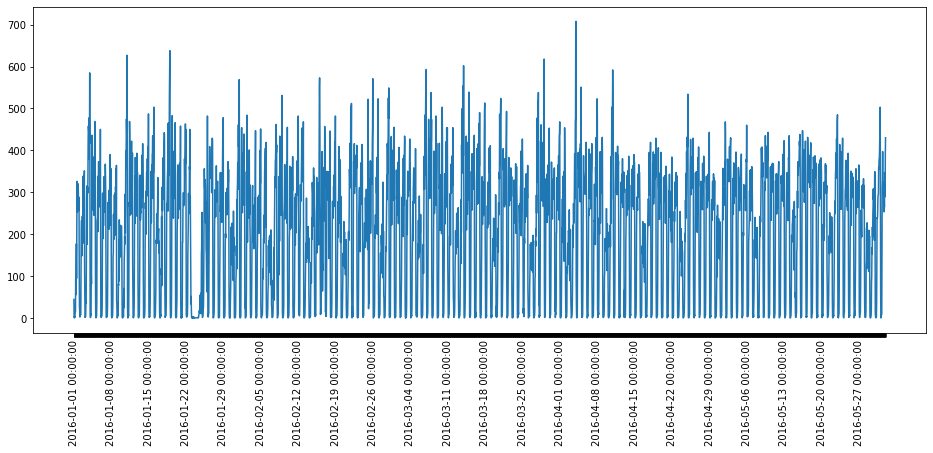

In [55]:
# отобразим ряд на графике

plt.figure(figsize=(16,6))
plt.plot(zone_df['count'])
ax = plt.gca()
plt.xticks(rotation=90)

[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % hours_in_week]
plt.show()

Проверим на стационарность исходный ряд

<Figure size 1080x720 with 0 Axes>

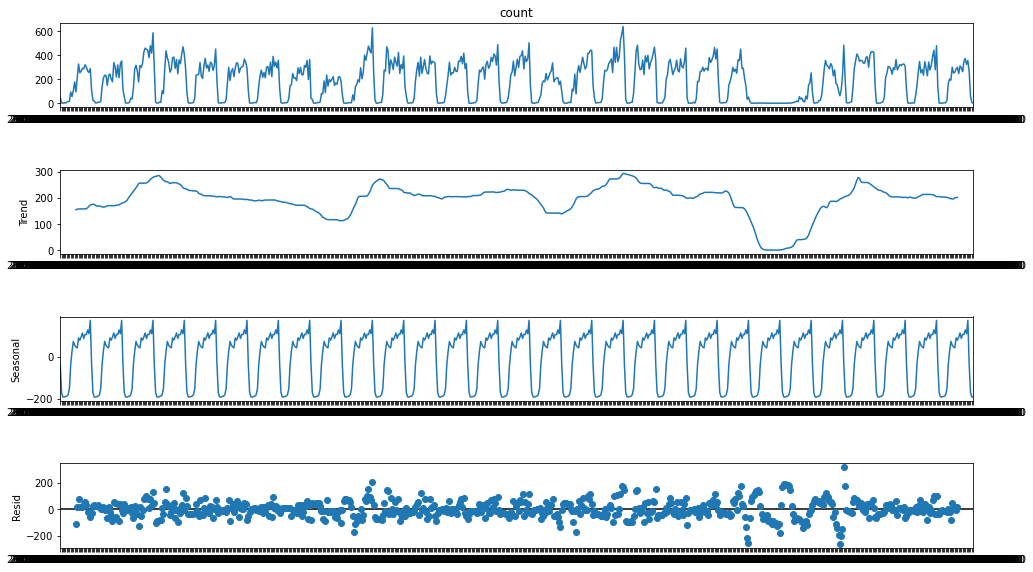

Критерий Дики-Фуллера: p=0.000000


In [56]:
plt.figure(figsize=(15,10))
fig = sm.tsa.seasonal_decompose(zone_df['count'].iloc[0:700], period=24).plot()
fig.set_size_inches((18, 9))
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zone_df['count'])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда.
То есть по этоиму критерию ряд стационарен. 

В то же время по графику видно:
- разброс дисперсии 
- сезонность на графике тренда
- заметна сезонность на графике остатков

что опровергает стационарность ряда.

**2.** Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [12]:
model = sm.OLS(zone_df['count'], zone_df.drop(['count'], axis=1)).fit()

In [58]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     160.8
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        12:11:21   Log-Likelihood:                -20079.
No. Observations:                3648   AIC:                         4.040e+04
Df Residuals:                    3529   BIC:                         4.113e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     205.0130      1.001    204.816      0.0

In [59]:
print(str("Коэффициент R-squared: %f" % model.rsquared))

Коэффициент R-squared: 0.843201


Рассмотрим остатки регрессионной модели

In [60]:
resid_df = pd.DataFrame(model.resid, columns={'resid'})

<Figure size 1080x720 with 0 Axes>

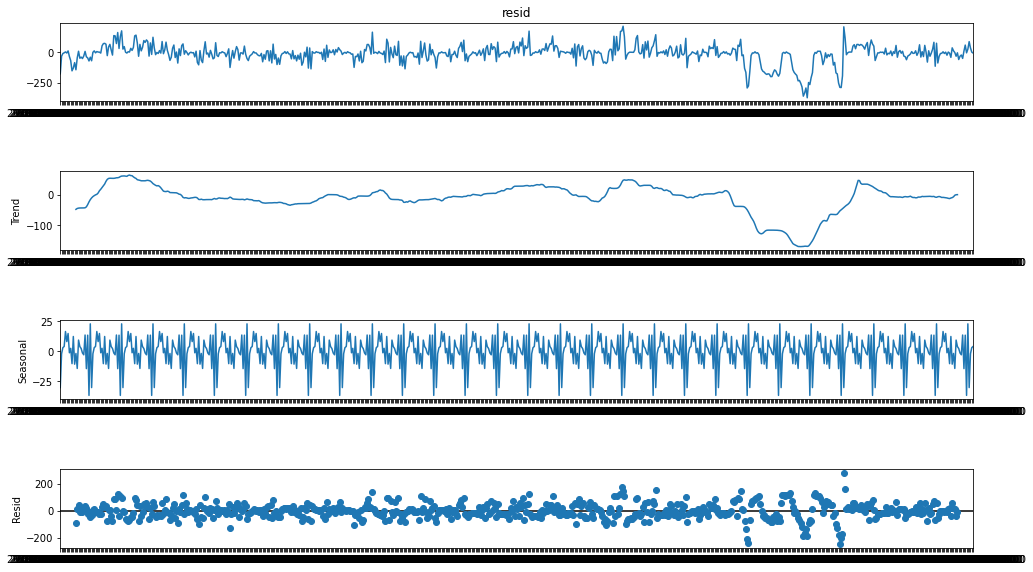

Критерий Дики-Фуллера: p=0.000000


In [61]:
plt.figure(figsize=(15,10))
fig = sm.tsa.seasonal_decompose(resid_df['resid'].iloc[0:700], period=24).plot()
fig.set_size_inches((18, 9))
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid_df['resid'])[1])

Ряд остатков OLS отличается от прошлого ряда количества поездок отсутствие сезонности на графике тренда.  
Ряд не стационарен по тем же причинам, что перечислены выше к STL декомпозиции ряда по количеству поездок.

**3.** Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [62]:
# Продифференируем ряд на сутки
resid_df['resid_d24'] = resid_df.resid - resid_df.resid.shift(24)

<Figure size 1080x720 with 0 Axes>

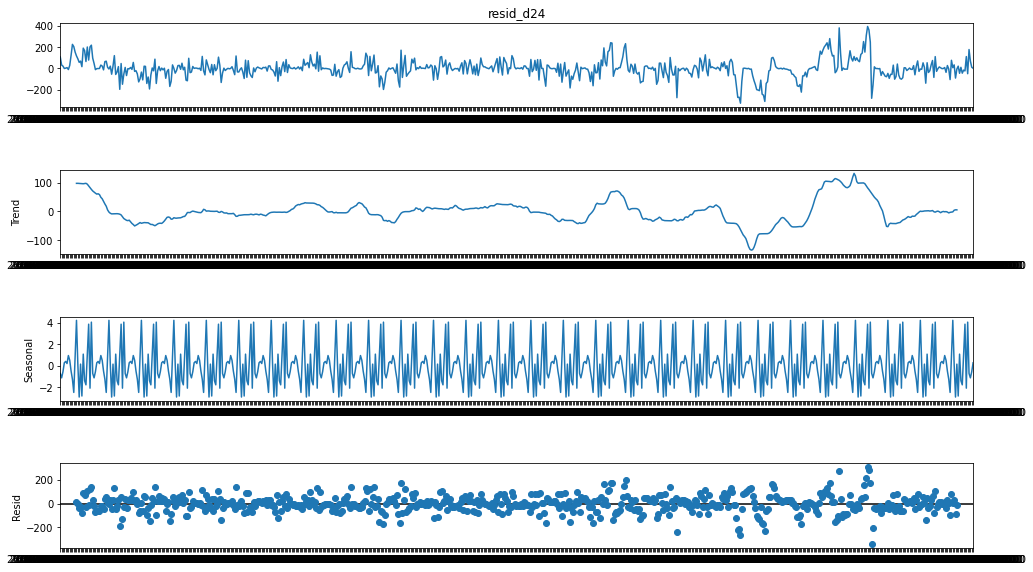

Критерий Дики-Фуллера: p=0.000000


In [63]:
plt.figure(figsize=(15,10))
fig = sm.tsa.seasonal_decompose(resid_df['resid_d24'].iloc[24:700], period=24).plot()
fig.set_size_inches((18, 9))
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid_df['resid_d24'].iloc[24:])[1])

In [64]:
#resid_df['resid_d24_d1'] = resid_df.resid_d24 - resid_df.resid_d24.shift(1)

In [65]:
# fig = sm.tsa.seasonal_decompose(resid_df['resid_d24_d1'].iloc[25:700], period=24).plot()
# fig.set_size_inches((18, 9))
# plt.show()

# print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid_df['resid_d24_d1'].iloc[25:])[1])

На последнем графике с дифференцированием ряда остатков по дням и по часам ряд выглядит более стационарным

**4.** Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров (p, q, P, Q). Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

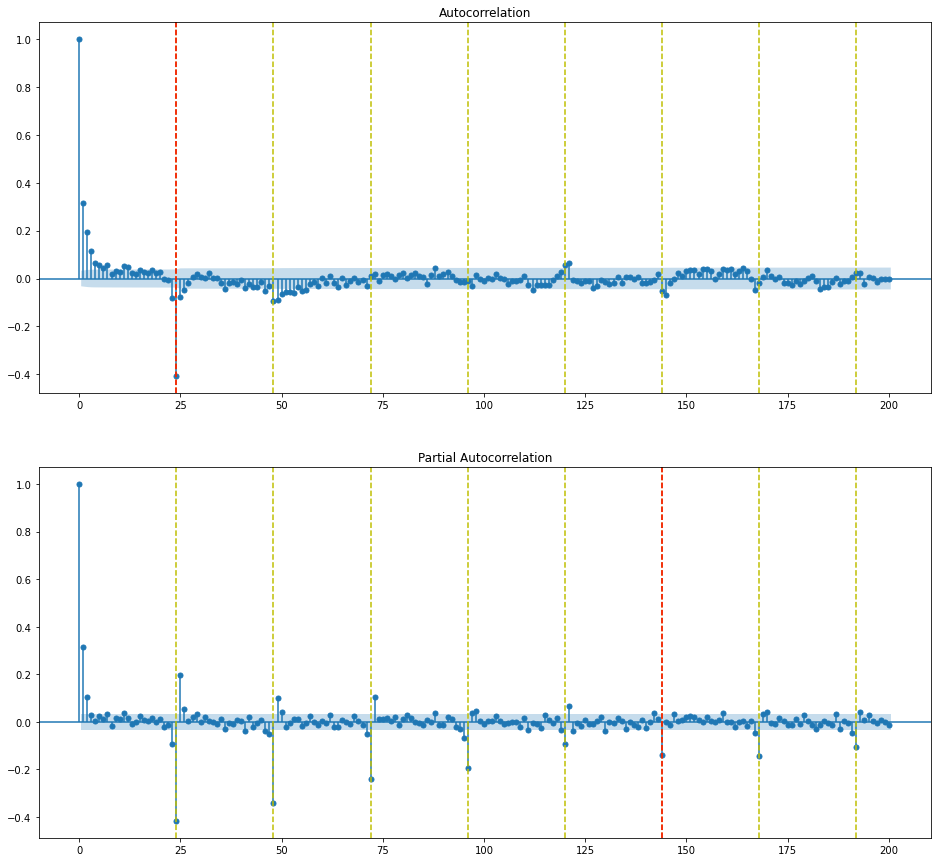

In [66]:
plt.figure(figsize=(16,15))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_df['resid_d24'][24:].values.squeeze(), lags=200, ax=ax)
for i in range(1,9): 
    plt.axvline(24*i, color='y', linestyle='--')

plt.axvline(24*1, color='r', linestyle='--')
    
    
ax1 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_df['resid_d24'][24:].values.squeeze(), lags=200, ax=ax1)
for i in range(1,9): 
    plt.axvline(24*i, color='y', linestyle='--')
    
plt.axvline(24*6, color='r', linestyle='--')

plt.show()

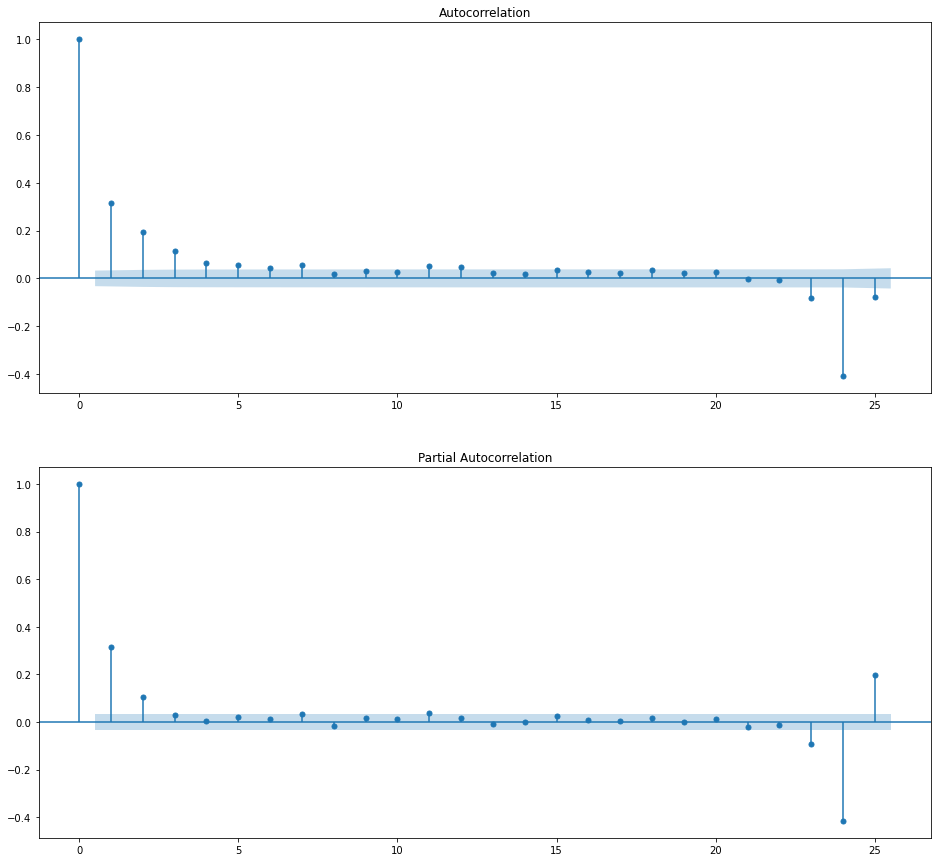

In [67]:
plt.figure(figsize=(16,15))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_df['resid_d24'][25:].values.squeeze(), lags=25, ax=ax)
    
ax1 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_df['resid_d24'][25:].values.squeeze(), lags=25, ax=ax1)


plt.show()

In [68]:
# (Не стал брать слишком большие значения. По этому параметры смещал в меньшую сторону)

# Последний значимый кратный сезону лаг на ACF
Q = 1
# Последний значимый лаг в рамках первого сезона на ACF
q = 2

# Последний значимый кратный сезону лаг на PACF
P = 6
# Последний значимый лаг в рамках первого сезона на PACF
p = 2

**5.** Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов (K)(K) или поменять порядки дифференцирования.

Определим функцию, которая будет строить модели SARIMA с помощью функции SARIMAX для разных значений параметров p,q,P,Q (по сетке) и выбирать наилучшую по метрике aic. Источник https://gist.github.com/JessicaFB/af4c9d12ec8314cff56b5e0f18b8e61c

In [69]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=50, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for comb in par:
        try:
            #print('start evaluation')
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            #print("ohoho")
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            #print("sg")
            ans.append([comb,output.aic])
            print(comb + " : " + output.aic)
            
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal AIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

In [70]:
Q = range(0, Q+1)
q = range(0, q+1)
P = range(0, P+1)
p = range(0, p+1)
D=1
d=0
s=24
exogen=zone_df.drop(['count'],axis=1)

In [71]:
from itertools import product
parameters = list(product(p, q, P, Q))
len(parameters)

126

In [72]:
%%time
sarimax_gridsearch(zone_df['count'], exogen, parameters, d=0, D=1, freq='H')

Wall time: 5h 35min 13s


,pqPQ,aic
96,"(2, 0, 6, 0)",38187.236777
54,"(1, 0, 6, 0)",38258.222467
94,"(2, 0, 5, 0)",38477.031382
52,"(1, 0, 5, 0)",38553.031592
12,"(0, 0, 6, 0)",38698.135506
92,"(2, 0, 4, 0)",38762.181678
50,"(1, 0, 4, 0)",38838.848939
10,"(0, 0, 5, 0)",39001.103642
90,"(2, 0, 3, 0)",39132.908019
48,"(1, 0, 3, 0)",39202.169259


Наилучший результат
(4, 0, 1, 0)	41301.783392  

Построим модель с наилучшими параметрами и сравним модель с исходным рядом

In [73]:
%%time
p=2
P=6
Q=0
q=0
D=1
d=0
s=24
ex=exogen
mod = sm.tsa.statespace.SARIMAX(zone_df['count'], exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

Wall time: 2h 41min 30s


In [74]:
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                 3648
Model:             SARIMAX(2, 0, 0)x(6, 1, 0, 24)   Log Likelihood              -19059.846
Date:                            Tue, 10 May 2022   AIC                          38375.692
Time:                                    20:49:50   BIC                          39163.431
Sample:                                01-01-2016   HQIC                         38656.917
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      1.9e+08   9.93e-07   1.91e+14      0.000     1.9e+08     1.9e+08
s1           -34.1355     14.383   

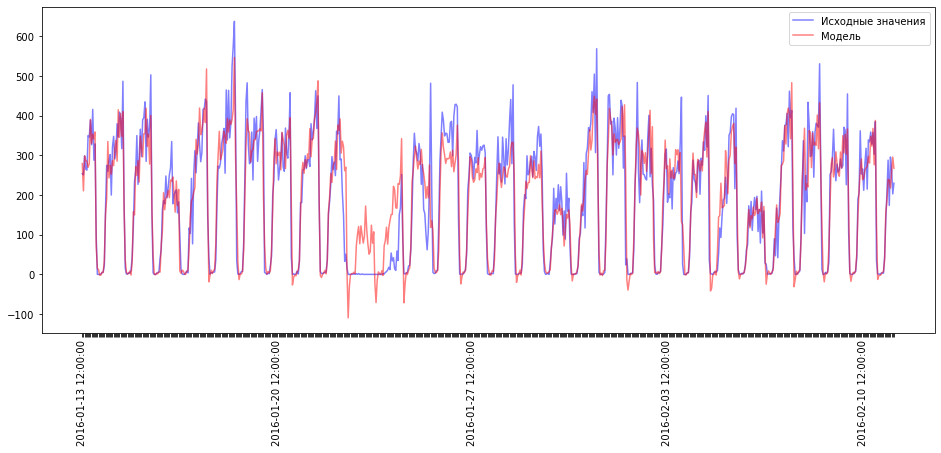

In [107]:
# отобразим модель ряда и исходный ряд на графике

plt.figure(figsize=(16,6))

plt.plot(zone_df['count'][300:1000], alpha=0.5, color='blue', label='Исходные значения')
plt.plot(mod.fittedvalues[300:1000], alpha=0.5, color='red', label='Модель')
plt.legend()
ax = plt.gca()
plt.xticks(rotation=90)

[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % hours_in_week]
plt.show()

In [103]:
#mod.save("saved_model_sarimax")

Модель хорошо описывает временной ряд в плане его сезонности.  
Критерий Льюнга-Бокса не опровергает гипотезу о неавтокоррелированности остатков.
Модель не учитывает фрагмента ряда похожий на аномалию. 

**6.** Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [120]:
# импортируем функции вычисления регрессионных метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  

При вычислении качества модели не будем учитывать первые остатки модели. Номер первого надежного остатка модели вычисляется по формуле

$$\max{\{(P+D)s+p+d, Qs+q}\}$$

In [119]:
start_resid = np.max([(P+D)*s+p+d, Q*s + q])
print(start_resid)

170


In [126]:
mae_value = mean_absolute_error(mod.fittedvalues[start_resid:1000], 
                    zone_df['count'][start_resid:1000])

mean_squared_error_value = mean_squared_error(mod.fittedvalues[start_resid:1000], 
                    zone_df['count'][start_resid:1000])

mean_absolute_percentage_error_value = mean_absolute_percentage_error(mod.fittedvalues[start_resid:1000], 
                                                                      zone_df['count'][start_resid:1000])

r2_score_value = r2_score(mod.fittedvalues[start_resid:1000], 
                          zone_df['count'][start_resid:1000])

print("mae: %f" % mae_value)
print("mean_squared_error_value: %f" % mean_squared_error_value)
print("mean_absolute_percentage_error_value: %f" % mean_absolute_percentage_error_value)
print("r2_score_value: %f" % r2_score_value)

mae: 42.050875
mean_squared_error_value: 3751.602678
mean_absolute_percentage_error_value: 0.713521
r2_score_value: 0.806979


Без сравнения с другими моделями сложно оценить качество по метрикам mae и mse. 
R2=0.81 указывает на неплохое объяснение дисперсии.  
mape приемлемого качества.

По графику видно,что есть периоды, плохо описываемые моделью. Возможно аномалии. Для улучшения качества можно попробовать добавить внешние признаки о праздниках или о погоде.

### Построим прогноз на май

In [141]:
predict=mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=exogen.iloc[:720])
predict_conf_int = predict.conf_int() 
ci=predict_conf_int.loc['2016-01-01':,]

In [142]:
df_large=pd.concat([df_1,df_2,df_3,df_4,df_5,df_6], axis=0)

df_large.rename(columns = {'Unnamed: 0':'time', str(zone):'count'}, inplace = True)
df_large.index = df_large.time

zone_df_large = df_large[['count']]

zone_df_large.head()

,count
time,
2016-01-01 00:00:00,44.0
2016-01-01 01:00:00,2.0
2016-01-01 02:00:00,0.0
2016-01-01 03:00:00,4.0
2016-01-01 04:00:00,1.0


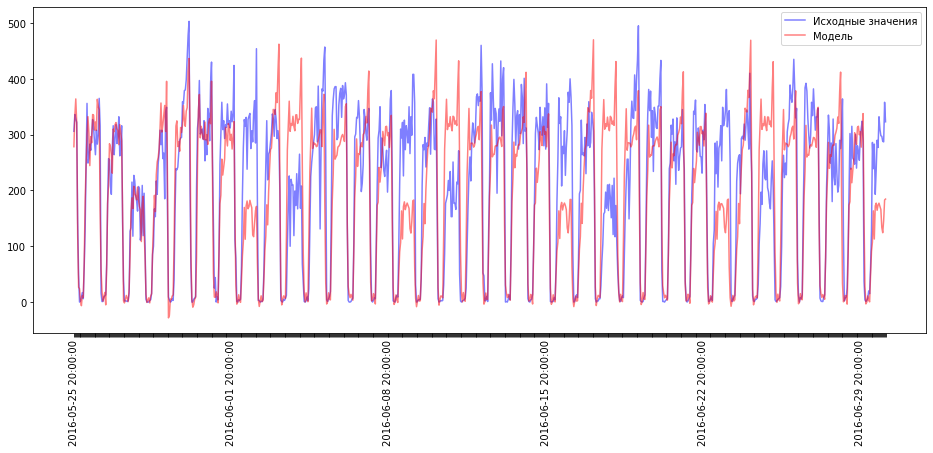

In [140]:
# отобразим модель ряда и исходный ряд на графике

plt.figure(figsize=(16,6))

plt.plot(zone_df_large['count'][3500:], alpha=0.5, color='blue', label='Исходные значения')
plt.plot(predict.predicted_mean[3500:].values, alpha=0.5, color='red', label='Модель')
plt.legend()
ax = plt.gca()
plt.xticks(rotation=90)

[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % hours_in_week/2]
plt.show()

за 06 месяц получается прогнозировать часть данных моделью.